#### Get multiple threads going

In [1]:
import os
os.environ['MKL_NUM_THREADS'] = '8'
os.environ['GOTO_NUM_THREADS'] = '8'
os.environ['OMP_NUM_THREADS'] = '8'
os.environ['openmp'] = 'True'

#### Import some libraries

In [112]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.models import Sequential, load_model
from keras import Input
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D

mpl.rcParams.update({'font.size': 16})

#### Define some short helper functions

In [3]:
# Returns an one-hot encoded array of integer 0-9
# 3 -> [0,0,0,1,0,0,0,0,0,0]
def onehot(ARRAY):
    return np.eye(10)[ARRAY].astype(np.uint8)

# Reshapes the data from the MNIST csv
# Returns a 2D representation (28x28)px of the raw MNIST data
def squareup(ARRAY):
    return ARRAY.reshape(28,28)

#### Load the data

In [4]:
# Try to load processed data first
try:
    with open('./input/inputs.npy',"rb") as f:
        inputs = np.load(f)
    with open('./input/outputs.npy',"rb") as f:
        outputs = np.load(f)
        
# Load data an process if not available      
except:
    data = np.genfromtxt('./input/train.csv', delimiter=',',skip_header=1,dtype=np.uint8)
    temp_inputs = data[:,1:]
    inputs = np.zeros((temp_inputs.shape[0],28,28,1))
    # Convert linear data from MNIST to 2D image
    for i in range(len(temp_inputs)):
        inputs[i,:28,:28,0] = squareup(temp_inputs[i])
    outputs = data[:,0]
    del temp_inputs, data
    # Save for faster loading next time
    np.save('./input/inputs.npy',inputs)
    np.save('./input/outputs.npy',outputs)
print(f'Input:\nShape:{inputs.shape}\n{inputs[0,:5,:5,0]}\n')
print(f'Output:\nShape:{outputs.shape}\n{outputs[:5]}\n')

Input:
Shape:(42000, 28, 28, 1)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]

Output:
Shape:(42000,)
[1 0 1 4 0]



#### View some MNIST handwritten digits

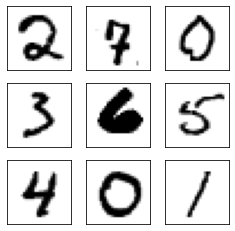

In [5]:
fig = plt.figure(figsize=(4,4))
for i in range(1,10):
    plt.subplot(f'33{i}')
    plt.tick_params(left=False,
                    labelleft=False,
                    bottom=False,
                    labelbottom=False
                   )
    plt.imshow(inputs[i*(np.round(np.random.random()*100)).astype(int),:29,:29,0], cmap='gray_r')
plt.show()

#### Prepare the data to be modeled

In [6]:
inputs = inputs/255.0 #Normalize
X_train, X_test, y_train, y_test = train_test_split(inputs,outputs,test_size = 0.2)


y_train_hot = onehot(y_train)
y_test_hot = onehot(y_test)

print(X_train.shape)
print(y_train_hot.shape)

(33600, 28, 28, 1)
(33600, 10)


In [7]:
X_train = inputs
y_train_hot = onehot(outputs)

#### Assemble a convolutional neural network

In [9]:
# Let's be civil and try to load the model first
model_filename = './convolutional.h5'

try:
    with open(model_filename,"rb") as f:
        model = load_model(model_filename)

# If that doesnt work, come back later when the model is built.
except: 
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation="relu"))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten(data_format=None))
    model.add(Dense(units=64))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    model.add(Dense(units=10))
    model.add(Activation("softmax"))
    model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])
    model.fit(X_train, y_train_hot, 
          epochs=16, 
          batch_size=420,
         )
    model.save(model_filename)


#### Evaluate model performance

In [10]:
model.evaluate(X_test, y_test_hot, batch_size=840)

8400/8400 [==============================] - 26s 3ms/step


[0.007829443202354014, 0.9977380812168122]

#### Use model to evaluate new images

In [11]:
out = model.predict(X_test)
len(out)

#### View the model output for 9 random data

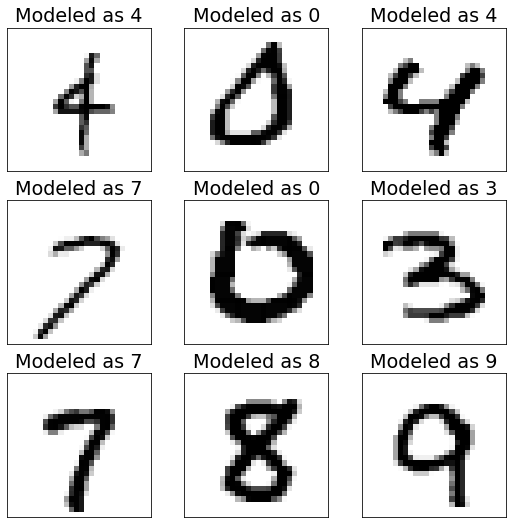

In [135]:
fig = plt.figure(figsize=(9,9))
for i in range(1,10):
    K = np.round(np.random.random()*len(submit)).astype(int)
    plt.subplot(f'33{i}')
    plt.tick_params(left=False,
                    labelleft=False,
                    bottom=False,
                    labelbottom=False
                   )
    plt.imshow(test_inputs[K,:29,:29,0],cmap='gray_r')
    plt.title(f'Modeled as {submit[K].argmax()}')
plt.show()

#### Model Performance 

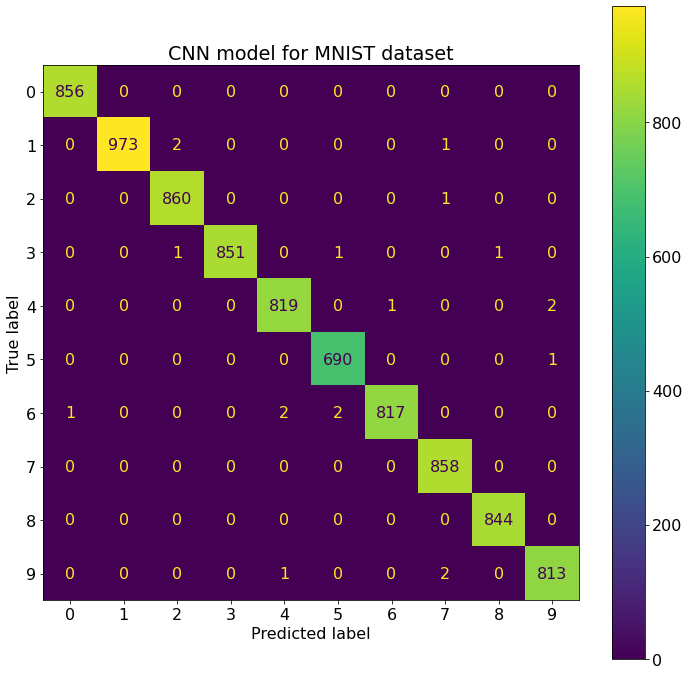

In [127]:
fig, axes = plt.subplots(figsize=(12, 12))
c_mat = confusion_matrix(y_test_hot.argmax(axis=1),out.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix = c_mat,display_labels=list(range(0,10)))
disp.plot(values_format='d',ax=axes)
plt.title('CNN model for MNIST dataset')
plt.show()

#### Create a submission for Kaggle.com 

In [54]:
data = np.genfromtxt('./input/test.csv', delimiter=',',skip_header=1,dtype=np.uint8)
temp_inputs = data
test_inputs = np.zeros((temp_inputs.shape[0],28,28,1))
# Convert linear data from MNIST to 2D image
for i in range(len(temp_inputs)):
    test_inputs[i,:28,:28,0] = squareup(temp_inputs[i])
outputs = data[:,0]
del temp_inputs, data

In [56]:
# Normalize
test_inputs=test_inputs/255.0
submit = model.predict(test_inputs)

In [77]:
submit_values = np.zeros((len(submit),2),dtype=int)
for i in range(len(submit)):
    submit_values[i,0] = i+1
    submit_values[i,1] = submit[i].argmax()
submit_values[0:5]

In [93]:
np.savetxt('./submission.csv',
           submit_values,
           delimiter = ',',
           newline='\n',
           header='ImageId,Label',
           fmt='%d')